# Experiment: Cell-Type-Adjusted Spatial Stickiness

Use this notebook to compute **cell-type-adjusted stickiness** (spatial structure beyond cell-type composition), inspect significance, and run quick diagnostics.


In [61]:
from __future__ import annotations

from pathlib import Path
import importlib
import sys

import numpy as np
import pandas as pd
import scanpy as sc

def find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "celltype_adjusted_stickiness.py").exists():
            return candidate
    raise FileNotFoundError("Could not find repo root from current working directory.")

REPO_ROOT = find_repo_root(Path.cwd().resolve())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import celltype_adjusted_stickiness as ctas
ctas = importlib.reload(ctas)

stickiness = ctas.stickiness
stickiness_diagnostics = ctas.stickiness_diagnostics

print(f"Repo root: {REPO_ROOT}")


Repo root: /Users/christoffer/work/karolinska/development/NeighborNorm


## Load AnnData
Set `DATA_PATH` to your `.h5ad` file.


In [62]:
DATA_PATH = "/Volumes/processing2/BALO/baloMS_indep_clust_balo_MANA_SC.h5ad"  # change this
adata = sc.read_h5ad(DATA_PATH)
adata


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 202751 × 5101
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_id', 'n_genes_by_counts', 'n_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'gmm_mana_5', 'gmm_mana_8', 'gmm_mana_10', 'gmm_mana_12', 'gmm_mana_15', 'gmm_mana_20'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_mana_gauss_params', 'gmm_mana_10_colors', 'gmm_mana_15_colors', 'gmm_mana_5_colors', 'gmm_mana_8_colors', 'hvg', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_

In [63]:
print(f"n_obs={adata.n_obs:,}, n_vars={adata.n_vars:,}")
print("obs columns (first 20):", list(adata.obs.columns)[:20])
print("obsm keys:", list(adata.obsm.keys()))
print("obsp keys:", list(adata.obsp.keys()))

if "spatial" not in adata.obsm:
    raise KeyError("adata.obsm['spatial'] is required.")

CTAS_CELL_TYPE_KEY = "cell_type" if "cell_type" in adata.obs else "leiden_2"
if CTAS_CELL_TYPE_KEY not in adata.obs:
    raise KeyError("Need a cell type column (expected 'cell_type' or 'leiden_2').")

CTAS_CONN_KEY = (
    "spatial_neighbors_connectivities"
    if "spatial_neighbors_connectivities" in adata.obsp
    else "connectivities"
)
if CTAS_CONN_KEY not in adata.obsp:
    raise KeyError("Need a connectivities graph in adata.obsp.")

print("Using cell_type_key:", CTAS_CELL_TYPE_KEY)
print("Using connectivities_key:", CTAS_CONN_KEY)


n_obs=202,751, n_vars=5,101
obs columns (first 20): ['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_id', 'n_genes_by_counts', 'n_counts', 'n_genes', 'leiden_0.5', 'leiden_1']
obsm keys: ['X_mana_gauss', 'X_pca', 'X_scVI', 'X_umap', 'spatial']
obsp keys: ['connectivities', 'distances', 'spatial_connectivities', 'spatial_distances']
Using cell_type_key: leiden_2
Using connectivities_key: connectivities


## Run Cell-Type-Adjusted Stickiness
Optional prefiltering below can drastically reduce runtime on large datasets.


In [72]:
USE_PREFILTER = True
MIN_DETECTED_CELLS = 50
MAX_DETECT_FRAC = 0.98
N_TOP_HVG = 4000

adata_run = adata
if USE_PREFILTER:
    mat = adata.layers["counts"] if "counts" in adata.layers else adata.X
    detected = np.asarray((mat > 5).sum(axis=0)).ravel()
    detect_frac = detected / max(1, adata.n_obs)

    gene_mask = detected >= MIN_DETECTED_CELLS
    if MAX_DETECT_FRAC is not None:
        gene_mask &= detect_frac <= MAX_DETECT_FRAC

    adata_pref = adata[:, gene_mask].copy()
    layer_for_hvg = "counts" if "counts" in adata_pref.layers else None

    if adata_pref.n_vars > N_TOP_HVG:
        sc.pp.highly_variable_genes(
            adata_pref,
            layer=layer_for_hvg,
            flavor="seurat_v3",
            n_top_genes=min(N_TOP_HVG, adata_pref.n_vars),
            inplace=True,
        )
        adata_run = adata_pref[:, adata_pref.var["highly_variable"].values].copy()
    else:
        adata_run = adata_pref

print(f"Running stickiness on {adata_run.n_vars:,} genes (from {adata.n_vars:,}).")


Running stickiness on 1,021 genes (from 5,101).


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [73]:
ctas_df = stickiness(
    adata_run,
    layer="counts" if "counts" in adata_run.layers else None,
    cell_type_key=CTAS_CELL_TYPE_KEY,
    total_counts_key="total_counts",
    connectivities_key=CTAS_CONN_KEY,
    key_added="stickiness",
    n_perm=20,  # raise to 200+ for final results
    random_state=0,
    compute_within_cell_type=False,  # set True if you need withinCT_* columns
    min_cells_per_type=50,
    store_residuals=False,
    copy=False,
    show_progress=True,
)

ctas_df.sort_values("z", ascending=False).head(30)


Permutation null: 100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


,gene,stickiness_resid,stickiness_naive,null_mean,null_sd,z,pval,qval,detection_rate,rank_naive,rank_resid,rank_delta
578,MT-CO1,0.568469,0.978697,-6.630811e-05,0.000757,751.162503,0.047619,0.047619,0.933041,1.0,1.0,0.0
210,CRYAB,0.460292,0.903484,-3.894405e-04,0.000778,591.840676,0.047619,0.047619,0.631760,8.0,10.0,2.0
361,GFAP,0.552329,0.978340,-8.730865e-05,0.000957,577.021680,0.047619,0.047619,0.807301,2.0,2.0,0.0
56,APOD,0.540190,0.913509,-3.342506e-04,0.000944,572.369296,0.047619,0.047619,0.595731,6.0,4.0,-2.0
778,RPL13,0.441196,0.877068,-1.682837e-04,0.000777,567.818922,0.047619,0.047619,0.717861,12.0,11.0,-1.0
579,MT-CO2,0.538863,0.977002,-1.013236e-04,0.000961,560.569933,0.047619,0.047619,0.933150,3.0,5.0,2.0
556,MBP,0.535395,0.945195,-3.016630e-04,0.000991,540.286439,0.047619,0.047619,0.778842,5.0,6.0,1.0
345,FTH1,0.546226,0.947117,1.464188e-04,0.001046,521.890502,0.047619,0.047619,0.858807,4.0,3.0,-1.0
996,VIM,0.423669,0.895750,-2.557548e-04,0.000822,515.515879,0.047619,0.047619,0.607297,10.0,13.0,3.0
890,SPP1,0.524025,0.911130,2.603578e-04,0.001041,503.148801,0.047619,0.047619,0.523307,7.0,7.0,0.0


In [74]:
print("Stored in adata_run.varm keys:", list(adata_run.varm.keys()))
print("Stored in adata_run.uns keys:", [k for k in adata_run.uns.keys() if k.startswith("stickiness")])

pd.DataFrame.from_records(adata_run.varm["stickiness"]).head()


Stored in adata_run.varm keys: ['PCs', 'stickiness']
Stored in adata_run.uns keys: ['stickiness']


,stickiness_resid,stickiness_naive,null_mean,null_sd,z,pval,qval,detection_rate,rank_naive,rank_resid,rank_delta
0,0.032735,0.287718,-0.000415,0.000960,34.548296,0.047619,0.047619,0.159901,701.0,676.0,-25.0
1,0.073816,0.433306,-0.000248,0.000816,90.769533,0.047619,0.047619,0.185671,271.0,337.0,66.0
2,0.024644,0.258393,-0.000437,0.000931,26.936569,0.047619,0.047619,0.133622,793.0,778.0,-15.0
3,0.198219,0.542148,-0.000076,0.002994,66.231610,0.047619,0.047619,0.041129,138.0,52.0,-86.0
4,0.213669,0.532375,0.000753,0.001983,107.371968,0.047619,0.047619,0.037657,144.0,42.0,-102.0


## Diagnostics
Check whether detection-rate coupling drops after adjustment and whether marker genes drop in rank.


In [75]:
marker_genes = ["COL4A1", "MBP", "GFAP"]
diag = stickiness_diagnostics(ctas_df, marker_genes=marker_genes)

print(
    "Spearman corr(detection_rate, naive stickiness):",
    diag["corr_detection_naive_spearman"],
)
print(
    "Spearman corr(detection_rate, residual stickiness):",
    diag["corr_detection_resid_spearman"],
)

diag["marker_rank_shift"]


Spearman corr(detection_rate, naive stickiness): 0.5301576591172725
Spearman corr(detection_rate, residual stickiness): -0.327292570924651


,gene,rank_naive,rank_resid,rank_delta
0,MBP,5.0,6.0,1.0
1,GFAP,2.0,2.0,0.0
2,COL4A1,105.0,41.0,-64.0


In [76]:
top_adjusted = ctas_df.sort_values("z", ascending=False)[["gene", "z", "qval", "rank_resid"]].head(20)
top_naive = ctas_df.sort_values("stickiness_naive", ascending=False)[["gene", "stickiness_naive", "rank_naive"]].head(20)

print("Top by adjusted z:")
top_adjusted

print("Top by naive stickiness:")
top_naive


Top by adjusted z:
Top by naive stickiness:


,gene,stickiness_naive,rank_naive
578,MT-CO1,0.978697,1.0
361,GFAP,0.978340,2.0
579,MT-CO2,0.977002,3.0
345,FTH1,0.947117,4.0
556,MBP,0.945195,5.0
56,APOD,0.913509,6.0
890,SPP1,0.911130,7.0
210,CRYAB,0.903484,8.0
787,S100B,0.899680,9.0
996,VIM,0.895750,10.0


## Optional: Spatial Visualization of Top Adjusted Genes


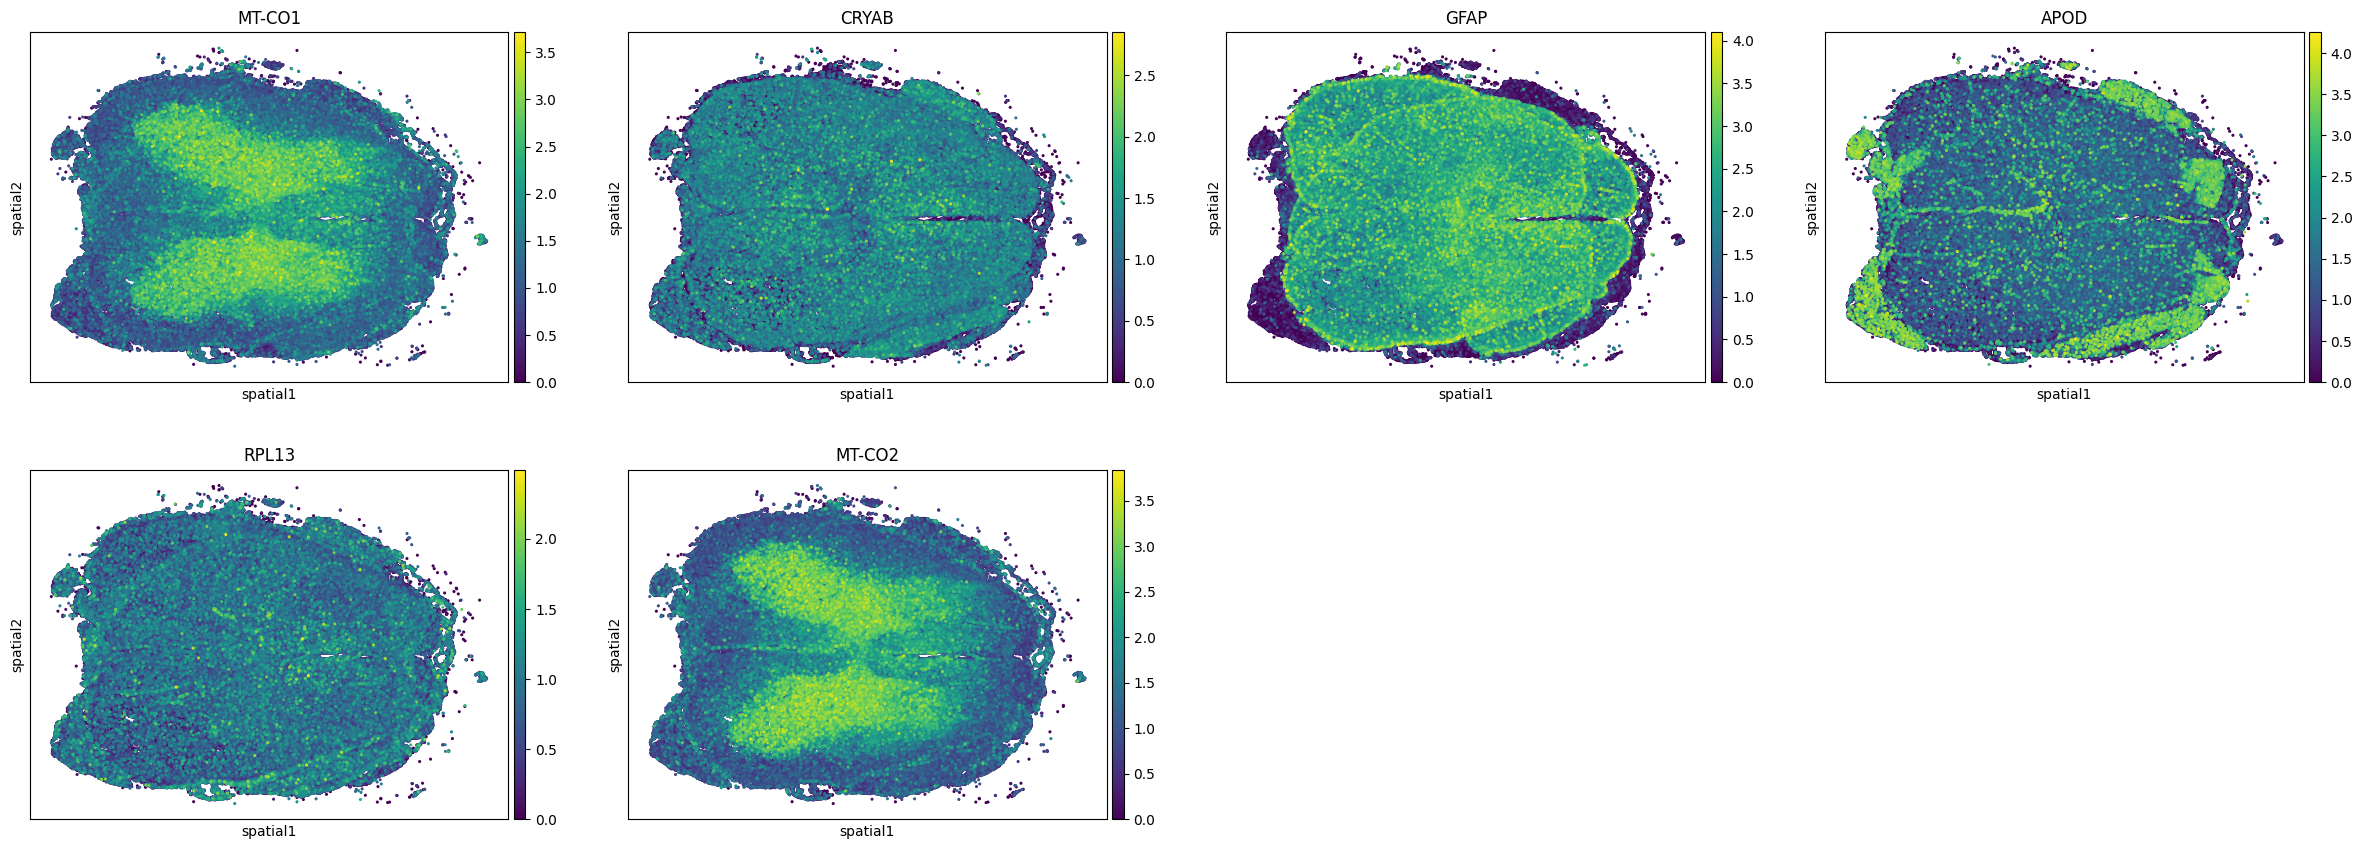

In [77]:
top_genes = ctas_df.sort_values("z", ascending=False)["gene"].head(6).tolist()
adata_run.obsm["X_spatial"] = np.asarray(adata_run.obsm["spatial"])
sc.pl.embedding(adata_run, basis="spatial", color=top_genes, size=20.0, cmap="viridis")


## Optional: Save Result


In [ ]:
OUT_PATH = REPO_ROOT / "data" / "your_data.sticky_adjusted.h5ad"
# adata_run.write_h5ad(OUT_PATH)
# print(f"Saved: {OUT_PATH}")
